In [10]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np
from numpy import dot, concatenate
from numpy.linalg import norm
from numpy.random import choice

import matplotlib.pyplot as plt

In [11]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        
    def forward(self, x):
        x=self.input_layer(x)
        x=x.tanh()
        for layer in self.hidden:
            x=layer(x)
            x=x.tanh()
        x=self.output_layer(x)
        return x

    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [ ]:
RES=50
EPOCHS=1000
BATCH_SIZE=100
LEARNING_RATE=0.1
SAMPLE_SIZE=10

NETWORK_ARCHITECTURES=[[64,8,4],[8,64,8],[64,8,64]]

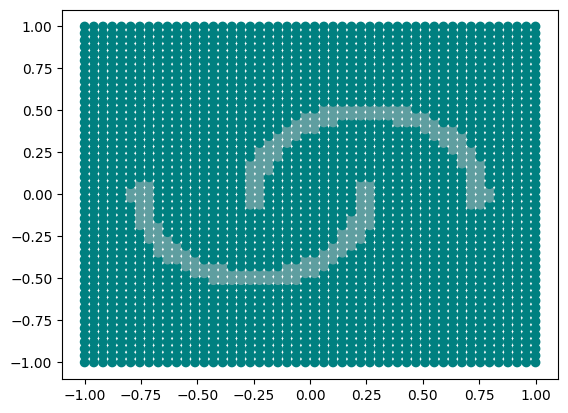

In [12]:
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

encode_inputs=lambda x: 1 if (abs((x[0]+0.25)**2+x[1]**2-0.25)<0.05 and x[1]<0.1) or (abs((x[0]-0.25)**2+x[1]**2-0.25)<0.05 and x[1]>-0.1) else 0
Y=np.array([encode_inputs(x) for x in X])

X=torch.from_numpy(X).float()
Y=torch.from_numpy(Y).float()

colors=np.full(len(Y), 'cadetblue')
colors[Y==0]='teal'

plt.scatter(X[:,0],X[:,1],c=colors)

In [13]:
def random_sample(X,Y,size):
    ind_zeros=np.array([k for k in range(len(X)) if Y[k]==0])
    ind_ones=np.array([k for k in range(len(X)) if Y[k]==1])
    return concatenate((choice(ind_zeros,size=size),choice(ind_ones,size=size)))

In [14]:
def layer_stiffness(epochs,learning_rate,batch_size,hidden_sizes,init=False):
    model = NeuralNet(2,hidden_sizes,2)
    ReLU_glorot_init(model)

    def next_batch(inputs, targets, batch_size):
        for i in range(0, inputs.shape[0], batch_size):
            yield (inputs[i:i + batch_size], targets[i:i + batch_size])

    opt = SGD(model.parameters(), lr=learning_rate)
    lossFunc = nn.CrossEntropyLoss()

    def training():
        trainLoss = 0
        samples = 0
        model.train()
        for batchX, batchY in next_batch(X, Y, batch_size):
            predictions = model(batchX)
            loss = lossFunc(predictions, batchY.long())
            opt.zero_grad()
            loss.backward()
            opt.step()
            samples += len(batchY)
            trainLoss += loss.item()*len(batchY)
        return trainLoss/samples

    def get_dots():
        N_h=len(model.hidden)
        grads_input_layer=[]
        grads_hidden_layers=[[] for n in range(N_h)]
        grads_output_layer=[]

        for x,y in zip(X,Y):
            predictions = model(x)
            loss = lossFunc(predictions, y.long())
            opt.zero_grad()
            loss.backward()

            gradient_input_layer=[]
            gradient_input_layer+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient_input_layer+=model.input_layer.bias.grad.tolist()
            gradient_input_layer=np.array(gradient_input_layer)
            if np.linalg.norm(gradient_input_layer)!=0:
                grads_input_layer.append(gradient_input_layer/norm(gradient_input_layer))
            else:
                grads_input_layer.append(gradient_input_layer)

            for k,h_layer in enumerate(model.hidden):
                gradient=[]
                gradient+=torch.flatten(h_layer.weight.grad).tolist()
                gradient+=h_layer.bias.grad.tolist()
                gradient=np.array(gradient)
                if norm(gradient)!=0:
                    grads_hidden_layers[k].append(gradient/norm(gradient))
                else:
                    grads_hidden_layers[k].append(gradient)

            gradient_output_layer=[]
            gradient_output_layer+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient_output_layer+=model.output_layer.bias.grad.tolist()
            gradient_output_layer=np.array(gradient_output_layer)
            if norm(gradient_output_layer)!=0:
                grads_output_layer.append(gradient_output_layer/norm(gradient_output_layer))
            else:
                grads_output_layer.append(gradient_output_layer)

        dot_matrix_input_layer=[]
        dot_matrix_hidden_layers=[[] for n in range(N_h)]
        dot_matrix_output_layer=[]
        for i in range(len(X)):
            avg_dot_input=0
            avg_dot_hidden=np.zeros(N_h)
            avg_dot_output=0
            samples=0
            sample_ind=random_sample(X,Y,SAMPLE_SIZE)
            for j in sample_ind:        
                avg_dot_input+=dot(grads_input_layer[i],grads_input_layer[j])
                for k in range(N_h):
                    avg_dot_hidden[k]+=dot(grads_hidden_layers[k][i],grads_hidden_layers[k][j])
                avg_dot_output+=dot(grads_output_layer[i],grads_output_layer[j])
                samples+=1
            
            dot_matrix_input_layer.append(avg_dot_input/samples)
            for k,avg_dot in enumerate(avg_dot_hidden):
                dot_matrix_hidden_layers[k].append(avg_dot/samples)
            dot_matrix_output_layer.append(avg_dot_output/samples)
    
        return dot_matrix_input_layer, dot_matrix_hidden_layers, dot_matrix_output_layer
    if init:
        init_input_matrix,init_hidden_matrices,init_output_matrix=get_dots()
    for n in range(epochs):
        l=training()
        print('Epoch {}: Loss {:.3f}'.format(n+1,l))
        if l<0.01:
            break
    input_matrix,hidden_matrix,output_matrix=get_dots()
    if init:
        return init_input_matrix,init_hidden_matrices,init_output_matrix,input_matrix,hidden_matrix,output_matrix
    return input_matrix,hidden_matrix,output_matrix

In [15]:
dot_matrices=[]

for hidden_layers in NETWORK_ARCHITECTURES:
    D_1,D_2,D_3=layer_stiffness(EPOCHS,LEARNING_RATE,BATCH_SIZE,hidden_layers,False)
    dot_matrices.append([D_1,D_2,D_3])

Epoch 1: Loss 0.319
Epoch 2: Loss 0.282
Epoch 3: Loss 0.280
Epoch 4: Loss 0.280
Epoch 5: Loss 0.281
Epoch 6: Loss 0.281
Epoch 7: Loss 0.281
Epoch 8: Loss 0.281
Epoch 9: Loss 0.280
Epoch 10: Loss 0.280
Epoch 11: Loss 0.280
Epoch 12: Loss 0.280
Epoch 13: Loss 0.280
Epoch 14: Loss 0.280
Epoch 15: Loss 0.280
Epoch 16: Loss 0.280
Epoch 17: Loss 0.280
Epoch 18: Loss 0.280
Epoch 19: Loss 0.280
Epoch 20: Loss 0.279
Epoch 21: Loss 0.279
Epoch 22: Loss 0.279
Epoch 23: Loss 0.279
Epoch 24: Loss 0.279
Epoch 25: Loss 0.279
Epoch 26: Loss 0.279
Epoch 27: Loss 0.279
Epoch 28: Loss 0.279
Epoch 29: Loss 0.279
Epoch 30: Loss 0.278
Epoch 31: Loss 0.278
Epoch 32: Loss 0.278
Epoch 33: Loss 0.278
Epoch 34: Loss 0.278
Epoch 35: Loss 0.277
Epoch 36: Loss 0.277
Epoch 37: Loss 0.277
Epoch 38: Loss 0.277
Epoch 39: Loss 0.276
Epoch 40: Loss 0.276
Epoch 41: Loss 0.275
Epoch 42: Loss 0.275
Epoch 43: Loss 0.274
Epoch 44: Loss 0.274
Epoch 45: Loss 0.273
Epoch 46: Loss 0.273
Epoch 47: Loss 0.272
Epoch 48: Loss 0.271
E

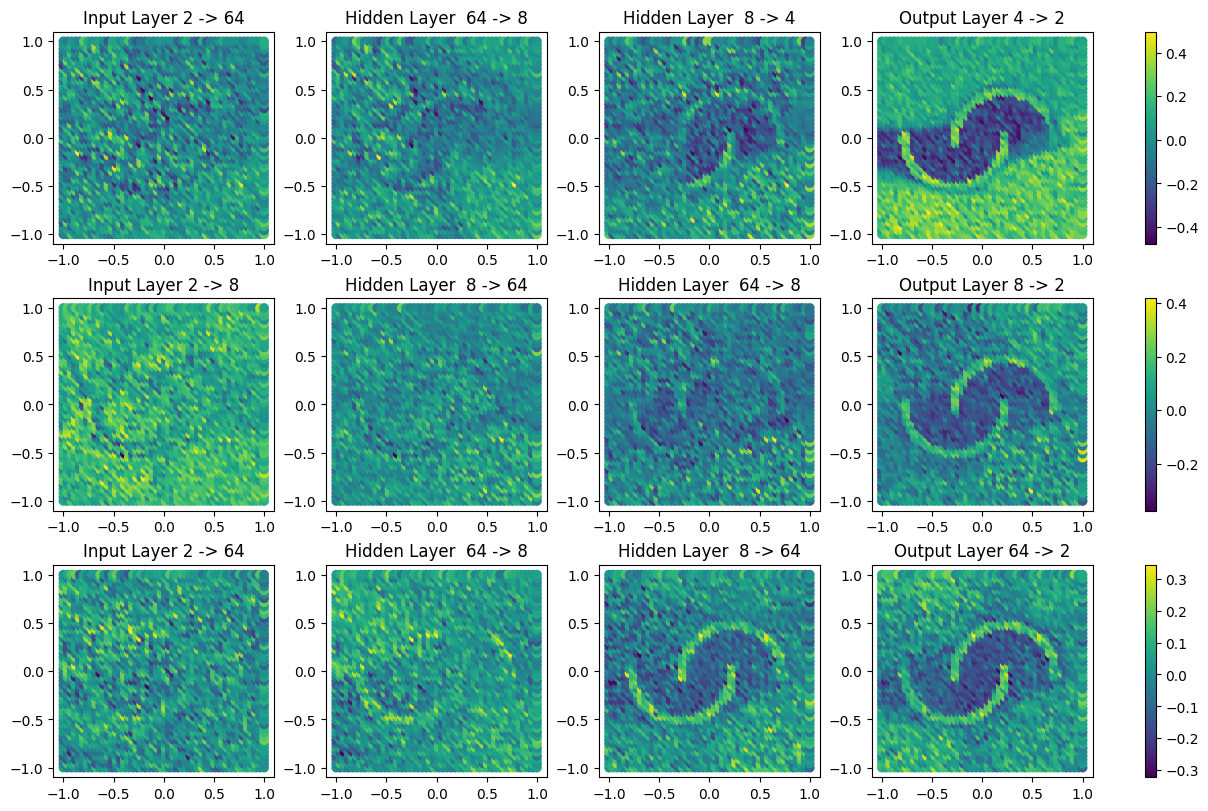

In [16]:
fig, axs = plt.subplots(3,4,figsize=(12,8),layout='constrained')

for k in range(3):
    axs[k,0].scatter(X[:,0], X[:,1],c=dot_matrices[k][0])
    axs[k,0].set_title('Input Layer {} -> {}'.format(2,NETWORK_ARCHITECTURES[k][0]))

    for n, matrix in enumerate(dot_matrices[k][1]):
        axs[k,1+n].scatter(X[:,0], X[:,1],c=matrix)
        axs[k,1+n].set_title('Hidden Layer  {} -> {}'.format(NETWORK_ARCHITECTURES[k][n],NETWORK_ARCHITECTURES[k][n+1]))

    pcm = axs[k,-1].scatter(X[:,0], X[:,1],c=dot_matrices[k][-1])
    axs[k,-1].set_title('Output Layer {} -> {}'.format(NETWORK_ARCHITECTURES[k][-1],2))

    fig.colorbar(pcm, ax=axs[k,:])

plt.savefig('plots/Stiffness_tanh.png')

In [17]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_sizes[0])
        for k in range(len(hidden_sizes)-1):
            self.hidden.append(nn.Linear(hidden_sizes[k], hidden_sizes[k+1]))
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=nn.LeakyReLU(0.2)(x)
        for layer in self.hidden:
            x=layer(x)
            x=nn.LeakyReLU(0.2)(x)
        x=self.output_layer(x)
        return x

In [18]:
def layer_stiffness(epochs,learning_rate,batch_size,hidden_sizes,init=False):
    model = NeuralNet(2,hidden_sizes,2)
    ReLU_glorot_init(model)

    def next_batch(inputs, targets, batch_size):
        for i in range(0, inputs.shape[0], batch_size):
            yield (inputs[i:i + batch_size], targets[i:i + batch_size])

    opt = SGD(model.parameters(), lr=learning_rate)
    lossFunc = nn.CrossEntropyLoss()

    def training():
        trainLoss = 0
        samples = 0
        model.train()
        for batchX, batchY in next_batch(X, Y, batch_size):
            predictions = model(batchX)
            loss = lossFunc(predictions, batchY.long())
            opt.zero_grad()
            loss.backward()
            opt.step()
            samples += len(batchY)
            trainLoss += loss.item()*len(batchY)
        return trainLoss/samples

    def get_dots():
        N_h=len(model.hidden)
        grads_input_layer=[]
        grads_hidden_layers=[[] for n in range(N_h)]
        grads_output_layer=[]

        for x,y in zip(X,Y):
            predictions = model(x)
            loss = lossFunc(predictions, y.long())
            opt.zero_grad()
            loss.backward()

            gradient_input_layer=[]
            gradient_input_layer+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient_input_layer+=model.input_layer.bias.grad.tolist()
            gradient_input_layer=np.array(gradient_input_layer)
            if norm(gradient_input_layer)!=0:
                grads_input_layer.append(gradient_input_layer/norm(gradient_input_layer))
            else:
                grads_input_layer.append(gradient_input_layer)

            for k,h_layer in enumerate(model.hidden):
                gradient=[]
                gradient+=torch.flatten(h_layer.weight.grad).tolist()
                gradient+=h_layer.bias.grad.tolist()
                gradient=np.array(gradient)
                if norm(gradient)!=0:
                    grads_hidden_layers[k].append(gradient/norm(gradient))
                else:
                    grads_hidden_layers[k].append(gradient)

            gradient_output_layer=[]
            gradient_output_layer+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient_output_layer+=model.output_layer.bias.grad.tolist()
            gradient_output_layer=np.array(gradient_output_layer)
            if norm(gradient_output_layer)!=0:
                grads_output_layer.append(gradient_output_layer/norm(gradient_output_layer))
            else:
                grads_output_layer.append(gradient_output_layer)

        dot_matrix_input_layer=[]
        dot_matrix_hidden_layers=[[] for n in range(N_h)]
        dot_matrix_output_layer=[]
        for i in range(len(X)):
            avg_dot_input=0
            avg_dot_hidden=np.zeros(N_h)
            avg_dot_output=0
            samples=0
            sample_ind=random_sample(X,Y,SAMPLE_SIZE)
            for j in sample_ind:        
                avg_dot_input+=dot(grads_input_layer[i],grads_input_layer[j])
                for k in range(N_h):
                    avg_dot_hidden[k]+=dot(grads_hidden_layers[k][i],grads_hidden_layers[k][j])
                avg_dot_output+=dot(grads_output_layer[i],grads_output_layer[j])
                samples+=1
            
            dot_matrix_input_layer.append(avg_dot_input/samples)
            for k,avg_dot in enumerate(avg_dot_hidden):
                dot_matrix_hidden_layers[k].append(avg_dot/samples)
            dot_matrix_output_layer.append(avg_dot_output/samples)
    
        return dot_matrix_input_layer, dot_matrix_hidden_layers, dot_matrix_output_layer
    if init:
        init_input_matrix,init_hidden_matrices,init_output_matrix=get_dots()
    for n in range(epochs):
        l=training()
        print('Epoch {}: Loss {:.3f}'.format(n+1,l))
        if l<0.01:
            break
    input_matrix,hidden_matrix,output_matrix=get_dots()
    if init:
        return init_input_matrix,init_hidden_matrices,init_output_matrix,input_matrix,hidden_matrix,output_matrix
    return input_matrix,hidden_matrix,output_matrix

In [19]:
dot_matrices=[]

for hidden_layers in NETWORK_ARCHITECTURES:
    D_1,D_2,D_3=layer_stiffness(EPOCHS,LEARNING_RATE,BATCH_SIZE,hidden_layers,False)
    dot_matrices.append([D_1,D_2,D_3])

Epoch 1: Loss 0.464
Epoch 2: Loss 0.313
Epoch 3: Loss 0.286
Epoch 4: Loss 0.279
Epoch 5: Loss 0.277


Epoch 6: Loss 0.276
Epoch 7: Loss 0.276
Epoch 8: Loss 0.275
Epoch 9: Loss 0.275
Epoch 10: Loss 0.275
Epoch 11: Loss 0.275
Epoch 12: Loss 0.275
Epoch 13: Loss 0.275
Epoch 14: Loss 0.274
Epoch 15: Loss 0.274
Epoch 16: Loss 0.274
Epoch 17: Loss 0.274
Epoch 18: Loss 0.274
Epoch 19: Loss 0.274
Epoch 20: Loss 0.273
Epoch 21: Loss 0.273
Epoch 22: Loss 0.273
Epoch 23: Loss 0.273
Epoch 24: Loss 0.272
Epoch 25: Loss 0.272
Epoch 26: Loss 0.272
Epoch 27: Loss 0.272
Epoch 28: Loss 0.271
Epoch 29: Loss 0.271
Epoch 30: Loss 0.270
Epoch 31: Loss 0.270
Epoch 32: Loss 0.270
Epoch 33: Loss 0.269
Epoch 34: Loss 0.269
Epoch 35: Loss 0.268
Epoch 36: Loss 0.267
Epoch 37: Loss 0.267
Epoch 38: Loss 0.266
Epoch 39: Loss 0.265
Epoch 40: Loss 0.264
Epoch 41: Loss 0.263
Epoch 42: Loss 0.262
Epoch 43: Loss 0.261
Epoch 44: Loss 0.260
Epoch 45: Loss 0.258
Epoch 46: Loss 0.257
Epoch 47: Loss 0.255
Epoch 48: Loss 0.253
Epoch 49: Loss 0.252
Epoch 50: Loss 0.250
Epoch 51: Loss 0.247
Epoch 52: Loss 0.245
Epoch 53: Loss 0.

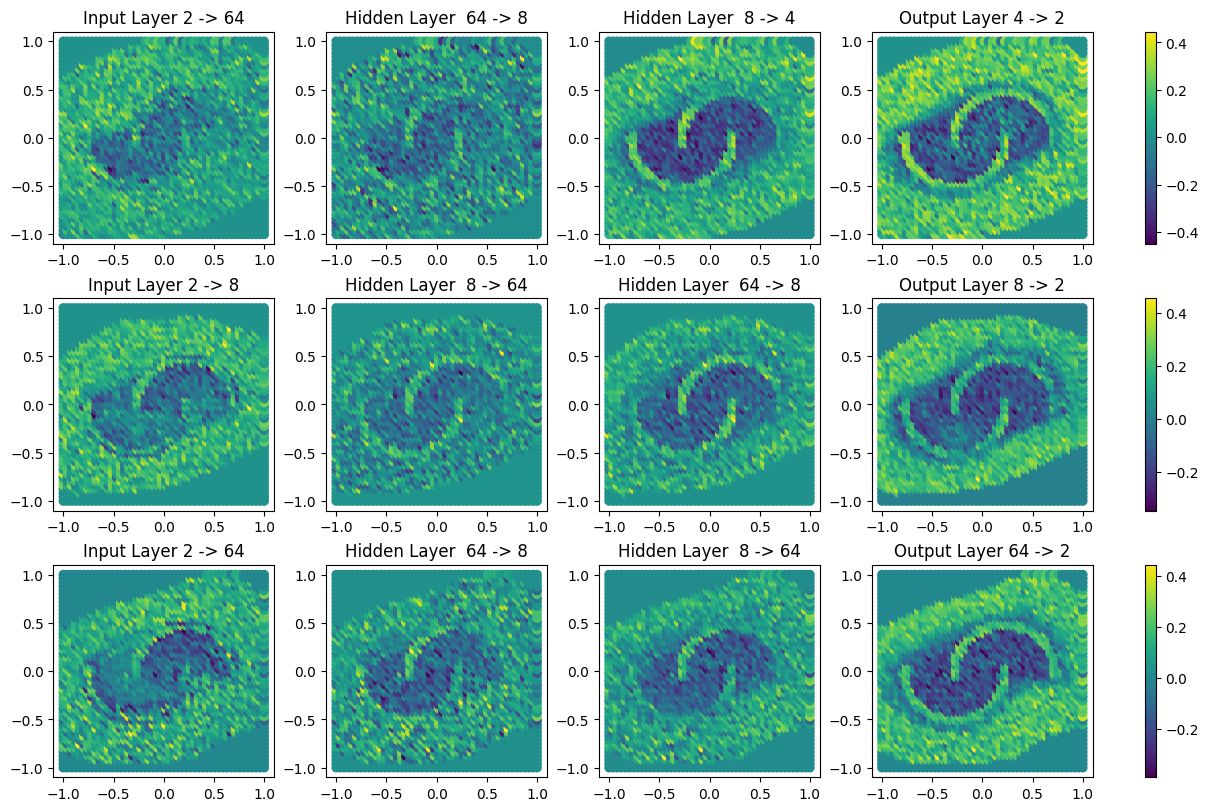

In [20]:
fig, axs = plt.subplots(3,4,figsize=(12,8),layout='constrained')

for k in range(3):
    axs[k,0].scatter(X[:,0], X[:,1],c=dot_matrices[k][0])
    axs[k,0].set_title('Input Layer {} -> {}'.format(2,NETWORK_ARCHITECTURES[k][0]))

    for n, matrix in enumerate(dot_matrices[k][1]):
        axs[k,1+n].scatter(X[:,0], X[:,1],c=matrix)
        axs[k,1+n].set_title('Hidden Layer  {} -> {}'.format(NETWORK_ARCHITECTURES[k][n],NETWORK_ARCHITECTURES[k][n+1]))

    pcm = axs[k,-1].scatter(X[:,0], X[:,1],c=dot_matrices[k][-1])
    axs[k,-1].set_title('Output Layer {} -> {}'.format(NETWORK_ARCHITECTURES[k][-1],2))

    fig.colorbar(pcm, ax=axs[k,:])

plt.savefig('plots/Stiffness_LeakyReLU.png')